## Tight-binding modelling of the Breathing Kagome System
### Here, we will follow the paper by Nagosa and Bolens "PhysRevB.99.165141" on the Breathing kagome system with trimerized couplings. 

In [1]:
using LinearAlgebra
using Makie 
using CairoMakie 
using Brillouin
using Printf
using PlotlyJS
using Symbolics
using StaticArrays

### Basis and Lattice geometry. 

Note that R1 and R2 are the basis in real space. They are related by a C_3 rotation. To complete the orbit of the C_3 group, we also define R3. R1, R2, and R3 show up in the momentum-space Hamiltonian 

--- Plotting the Wigner-Seitz cell in real space. 

--- Vertices of the real Wigner-Seitz cell (in reduced coordinates): 
  0.666667   0.333333 
  0.333333  -0.333333 
 -0.333333  -0.666667 
 -0.666667  -0.333333 
 -0.333333   0.333333 
  0.333333   0.666667 

--- Plotting the Wigner-Seitz cell in reciprocal space. 

--- Vertices of the reciprocal space Wigner-Seitz cell (in reduced coordinates): 
 -0.666667   0.333333 
 -0.333333   0.666667 
  0.333333   0.333333 
  0.666667  -0.333333 
  0.333333  -0.666667 
 -0.333333  -0.333333 

--- Vertices of the reciprocal space Wigner-Seitz cell (in cartesian coordinates): 
  2.094395   3.627599 
  4.188790  -0.000000 
  2.094395  -3.627599 
 -2.094395  -3.627599 
 -4.188790   0.000000 
 -2.094395   3.627599 



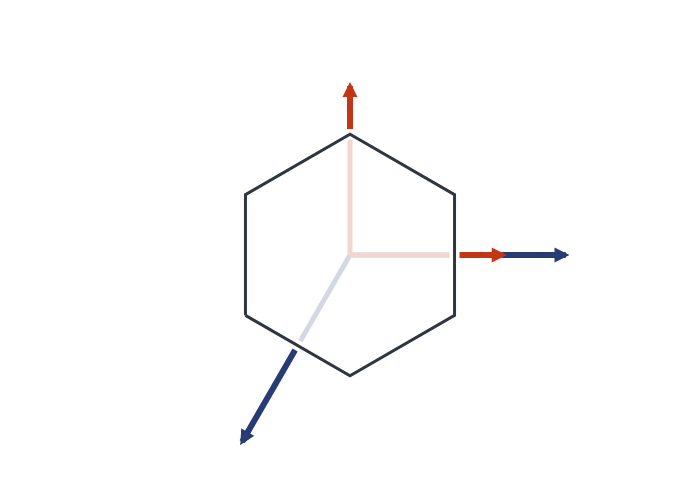

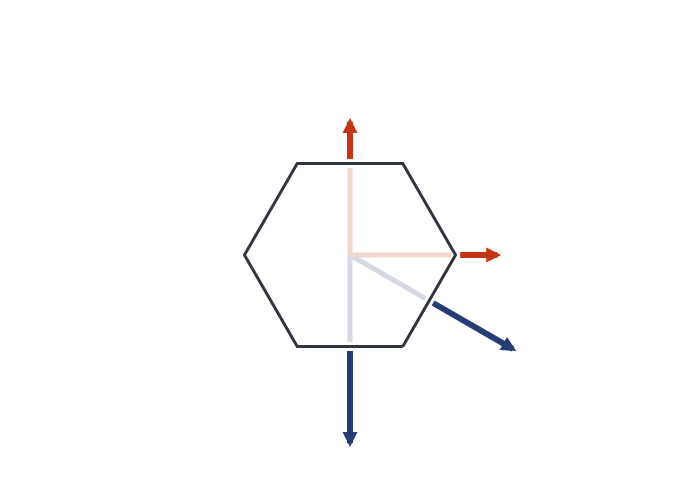

In [2]:
# Useful C_3 rotation
global const C_3::Matrix{Float64} = [cos(2.0*pi/3.0) -sin(2.0*pi/3.0); sin(2.0*pi/3.0) cos(2.0*pi/3.0)]

# Useful C_6 rotation
global const C_6::Matrix{Float64} = [cos(pi/3.0) -sin(pi/3.0); sin(pi/3.0) cos(pi/3.0)]


# Reciprocal and Direct Lattice   R1 and R2 are the basis vectors in the real space ! 
global const R1::Vector{Float64} = [-0.5, -0.5 * sqrt(3.0)]
global const R2::Vector{Float64} = C_3 * R1
global const R3::Vector{Float64} = C_3 * R2;

# Now, the reciprocal lattice 
global const R::Matrix{Float64} = [R1 R2]';
global const G::Matrix{Float64} = 2.0 * pi * inv(R');

let
    print("--- Plotting the Wigner-Seitz cell in real space. \n")
    print("\n")

    As = [R[i, :] for i ∈ 1 : size(R, 1)]
    real_wignerseitz = wignerseitz(As)

    vertices = real_wignerseitz.verts

    print("--- Vertices of the real Wigner-Seitz cell (in reduced coordinates): \n")
    for v ∈ vertices
        @printf("%10f %10f \n", v[1], v[2])
    end
    print("\n")

    pbzb = PlotlyJS.plot(real_wignerseitz)
    display(pbzb)

end

let
    print("--- Plotting the Wigner-Seitz cell in reciprocal space. \n")
    print("\n")

    G1 = G[1, :]; G2 = G[2, :]
    Gs = [G[i, :] for i ∈ 1 : size(G, 1)]
    recip_wignerseitz = wignerseitz(Gs)

    vertices = recip_wignerseitz.verts

    # Here, we want the cartesian coordinates of the corners (vertices of the FBZ). We also need the cartesian coordinates of the M point 
    global cart_v::Vector{Vector{Float64}} = similar(vertices)
    for i ∈ 1:size(cart_v, 1)
        red_v = vertices[i]
        cart_v[i] = red_v[1] * G1 + red_v[2] * G2
    end

    print("--- Vertices of the reciprocal space Wigner-Seitz cell (in reduced coordinates): \n")
    for v ∈ vertices
        @printf("%10f %10f \n", v[1], v[2])
    end
    print("\n")

    print("--- Vertices of the reciprocal space Wigner-Seitz cell (in cartesian coordinates): \n")
    for v ∈ cart_v
        @printf("%10f %10f \n", v[1], v[2])
    end
    print("\n")

    pbzb = PlotlyJS.plot(recip_wignerseitz)
    display(pbzb)

end

In [3]:

global const cK::SVector{2, Float64} = SVector{2, Float64}(cart_v[2])
global const cK_I::SVector{2, Float64} = @SVector [2.094395, 3.627599]
# Now, the K-Points 
global const high_symmetry_points = Dict{String, SVector{2, Float64}}(
    "K"=> cK, 
    "M"=> (cK + cK_I) / 2.0,
    "Γ"=> [0.0, 0.0] 
)


Dict{String, SVector{2, Float64}} with 3 entries:
  "M" => [3.14159, 1.8138]
  "Γ" => [0.0, 0.0]
  "K" => [4.18879, -8.88178e-16]

### Parameters and Construction of the Hamiltonian 

In the kagome system, there is a periodic pattern of corner-sharing upright triangles and inverted triangles. We want to consider strong Breathing anisotropy. We consider the model 
discussed in Bolens and Nagosa 

In [4]:
struct Params

    # we will use unicode characters to name the variables 

    # Parameters for the upright triangle 
    t1Δ::Float64
    t2Δ::Float64
    t3Δ::Float64
    # Parameters for the inverted triangle 
    t1∇::Float64
    t2∇::Float64
    t3∇::Float64
    

end


### Symmetry 

We will find the constraints imposed by C_3 on possible Bloch Hamiltonians

In [5]:
## How C_3 rotates the atomic sites 
global const C3_abc::Matrix{Float64} = [0.0 0.0 1.0; 1.0 0.0 0.0; 0.0 1.0 0.0]; 
## Check that it is order 3 (It is a cyclic permutation)
C3_abc^3


3×3 Matrix{Float64}:
 1.0  0.0  0.0
 0.0  1.0  0.0
 0.0  0.0  1.0

In [6]:
@variables ϕ1 ϕ2 ϕ3 ϕ1c ϕ2c ϕ3c H
H = [0 ϕ1c ϕ3; ϕ1 0 ϕ2c; ϕ3c ϕ2 0]
H

3×3 Matrix{Num}:
   0  ϕ1c   ϕ3
  ϕ1    0  ϕ2c
 ϕ3c   ϕ2    0

In [7]:
## Conjugation of the Hamiltonian by the C3 action 
C3_abc * H * inv(C3_abc)

3×3 Matrix{Num}:
 0.0  ϕ3c   ϕ2
  ϕ3  0.0  ϕ1c
 ϕ2c   ϕ1  0.0

In [8]:
# print k1, k2, k2 
let R1 = R1, R2 = R2, R3 = R3
    @variables k k1 k2 k3 kx ky 
    k = [kx ky]
    k1 = dot(k, R1); k2 = dot(k, R2); k3 = dot(k, R3)
    println("k₁ = ", k1)
    println("k₂ = ", k2)
    println("k₃ = ", k3)
end

k₁ = -0.5kx - 0.8660254037844386ky
k₂ = 0.9999999999999999kx - 2.220446049250313e-16ky
k₃ = -0.49999999999999956kx + 0.8660254037844387ky


We now would like to test whether the breathing anisotropy breaks C2 symmetry. There are many ways to do this. One simple method is to just plot the energies of the model,
and observe whether or not the spectra at C_2 related points are the same. One can also test this directly by diagonalizing the Hamiltonian at a random set of pairs with each pair being on the same C_2 orbit i.e. antipodal pairs (k, -k)

In [42]:
global const T1u  = @SArray ComplexF64[0.0 1.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
global const T2u  = @SArray ComplexF64[0.0 0.0 1.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
global const T3u  = @SArray ComplexF64[0.0 0.0 0.0; 0.0 0.0 1.0; 0.0 0.0 0.0];

# Implement the Hamiltonian in Nagosa's paper without spin-orbit interaction or magnetism 
@inline function EvalsHamBreathingKagomeNoSOC(k::Vector{Float64}, p::Params)
    kx::Float64 = k[1]; ky::Float64 = k[2] 
    Ham::SMatrix{3, 3, ComplexF64} = SMatrix{3, 3, ComplexF64}((p.t1Δ + p.t1∇ * exp(im * (0.5 * kx + 0.5 * sqrt(3.0) * ky))) * T1u + (p.t1Δ + p.t1∇ * exp(-im * kx)) * T3u + 
    (p.t1Δ + p.t1∇ * exp(im * (-0.5 * kx + 0.5 * sqrt(3.0) * ky))) * T2u)
    Hermitian(Ham + Ham')
end

@inline function EvalsHamBreathingKagomeNoSOC(k::SVector{2, Float64}, p::Params)
    kx::Float64 = k[1]; ky::Float64 = k[2] 
    Ham::SMatrix{3, 3, ComplexF64} = SMatrix{3, 3, ComplexF64}((p.t1Δ + p.t1∇ * exp(im * (0.5 * kx + 0.5 * sqrt(3.0) * ky))) * T1u + (p.t1Δ + p.t1∇ * exp(-im * kx)) * T3u + 
    (p.t1Δ + p.t1∇ * exp(im * (-0.5 * kx + 0.5 * sqrt(3.0) * ky))) * T2u)
    eigvals(Hermitian(Ham + Ham'))
end

@inline function EvalsHamBreathingKagomeNoSOC(k::Vector{Float64}, p::Params)
    kx::Float64 = k[1]; ky::Float64 = k[2] 
    Ham::SMatrix{3, 3, ComplexF64} = SMatrix{3, 3, ComplexF64}((p.t1Δ + p.t1∇ * exp(im * (0.5 * kx + 0.5 * sqrt(3.0) * ky))) * T1u + (p.t1Δ + p.t1∇ * exp(-im * kx)) * T3u + 
    (p.t1Δ + p.t1∇ * exp(im * (-0.5 * kx + 0.5 * sqrt(3.0) * ky))) * T2u)
    eigvals(Hermitian(Ham + Ham'))
end



EvalsHamBreathingKagomeNoSOC (generic function with 2 methods)

In [38]:
function plot_simple_kagome_bands(;p, seedname, kpath, title = Nothing)
    if title == Nothing
        title = seedname
    end
    eks = EvalsHamBreathingKagomeNoSOC.(kpath, Ref(p))

    nps_x = size(kpath, 1)
    xs = 1 : nps_x
    
    t1 = PlotlyJS.scatter(x = xs, y = map(e->e[1], eks), mode = "lines", line = attr(color = "purple", width = 4))
    t2 = PlotlyJS.scatter(x = xs, y = map(e->e[2], eks), mode = "lines", line = attr(color = "purple", width = 4))
    t3 = PlotlyJS.scatter(x = xs, y = map(e->e[3], eks), mode = "lines", line = attr(color = "purple", width = 4))
    lo = PlotlyJS.Layout(title = title,
                xaxis_showgrid = true,
                yaxis_showgrid = true,
                plot_bgcolor="rgba(0,0,0,0)",
                xaxis = attr(showgrid = true, showticklabels = false, linecolor = "black", linewidth = 5, showline = true, mirror = true),
                yaxis = attr(showgrid = true, showticklabels = true, linecolor = "black", linewidth = 5, showline = true, mirror = true),
                width = 510, 
                height = 510,
                showlegend = false)
    
    p = PlotlyJS.plot([t1, t2, t3], lo)
    #PlotlyJS.savefig(p, assets_dir * seedname * ".png")
    display(p)
end

plot_simple_kagome_bands (generic function with 1 method)

t1Δ = 1.0
t2Δ = 1.0
t3Δ = 1.0
t1∇ = 1.0
t2∇ = 1.0
t3∇ = 1.0


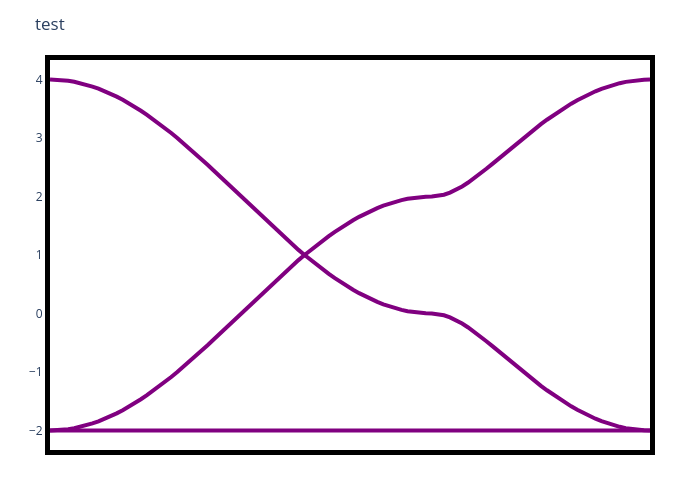

In [39]:
let nps::Int = 100, t1Δ = 1.0, t2Δ = 1.0, t3Δ = 1.0, t1∇ = 1.0, t2∇ = 1.0, t3∇ = 1.0
    p::Params = Params(t1Δ, t2Δ, t3Δ, t1∇, t2∇, t3∇)
    println("t1Δ = ", p.t1Δ)
    println("t2Δ = ", p.t2Δ)
    println("t3Δ = ", p.t3Δ)
    println("t1∇ = ", p.t1∇)
    println("t2∇ = ", p.t2∇)
    println("t3∇ = ", p.t3∇)
    
    kpath_nodes::Vector{SVector{2, Float64}} = [high_symmetry_points["Γ"], 
                    high_symmetry_points["K"], 
                    high_symmetry_points["M"], 
                    high_symmetry_points["Γ"]];
    kpath_fbz::Vector{Vector{Float64}} = interpolate(kpath_nodes, nps);
    kpath_fbz = [SVector{2, Float64}(v) for v ∈ kpath_fbz]
    plot_simple_kagome_bands(;p = p, seedname = "Standard K Path", kpath = kpath_fbz, title = Nothing)
end



t1Δ = 1.0
t2Δ = 1.0
t3Δ = 1.0
t1∇ = 1.0
t2∇ = 1.0
t3∇ = 1.0


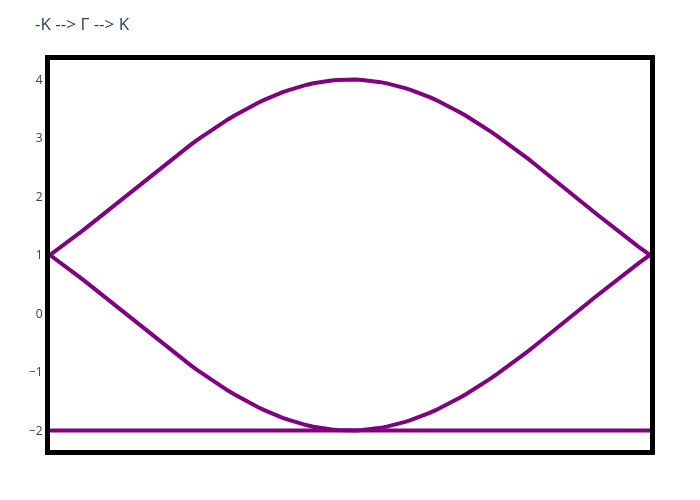

In [43]:
let nps::Int = 100, t1Δ = 1.0, t2Δ = 1.0, t3Δ = 1.0, t1∇ = 1.0, t2∇ = 1.0, t3∇ = 1.0
    p::Params = Params(t1Δ, t2Δ, t3Δ, t1∇, t2∇, t3∇)
    println("t1Δ = ", p.t1Δ)
    println("t2Δ = ", p.t2Δ)
    println("t3Δ = ", p.t3Δ)
    println("t1∇ = ", p.t1∇)
    println("t2∇ = ", p.t2∇)
    println("t3∇ = ", p.t3∇)
    
    kpath_nodes::Vector{SVector{2, Float64}} = [-high_symmetry_points["K"], 
                    high_symmetry_points["Γ"], 
                    high_symmetry_points["K"]];
    kpath_fbz::Vector{Vector{Float64}} = interpolate(kpath_nodes, nps);
    kpath_fbz = [SVector{2, Float64}(v) for v ∈ kpath_fbz]
    plot_simple_kagome_bands(;p = p, seedname = "-K --> Γ --> K", kpath = kpath_fbz, title = Nothing)
end


t1Δ = 1.0
t2Δ = 1.0
t3Δ = 1.0
t1∇ = 1.5
t2∇ = 1.5
t3∇ = 1.5


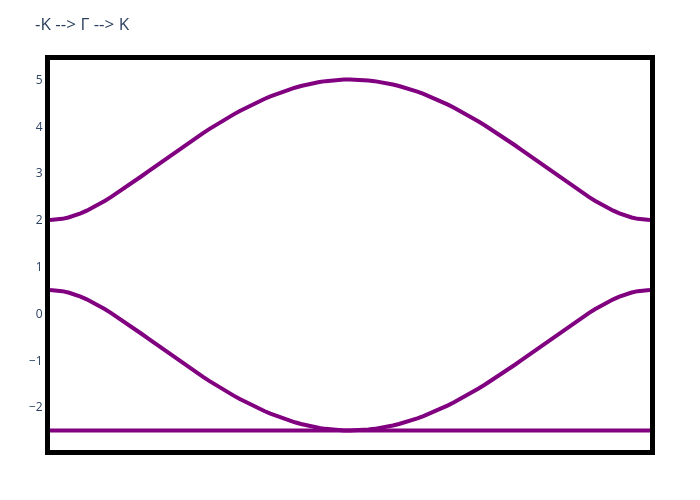

In [46]:
let nps::Int = 100, t1Δ = 1.0, t2Δ = 1.0, t3Δ = 1.0, t1∇ = 1.5, t2∇ = 1.5, t3∇ = 1.5
    p::Params = Params(t1Δ, t2Δ, t3Δ, t1∇, t2∇, t3∇)
    println("t1Δ = ", p.t1Δ)
    println("t2Δ = ", p.t2Δ)
    println("t3Δ = ", p.t3Δ)
    println("t1∇ = ", p.t1∇)
    println("t2∇ = ", p.t2∇)
    println("t3∇ = ", p.t3∇)
    
    kpath_nodes::Vector{SVector{2, Float64}} = [-high_symmetry_points["K"], 
                    high_symmetry_points["Γ"], 
                    high_symmetry_points["K"]];
    kpath_fbz::Vector{Vector{Float64}} = interpolate(kpath_nodes, nps);
    kpath_fbz = [SVector{2, Float64}(v) for v ∈ kpath_fbz]
    plot_simple_kagome_bands(;p = p, seedname = "-K --> Γ --> K", kpath = kpath_fbz, title = Nothing)
end


t1Δ = 1.0
t2Δ = 1.0
t3Δ = 1.0
t1∇ = 1.5
t2∇ = 1.5
t3∇ = 1.5


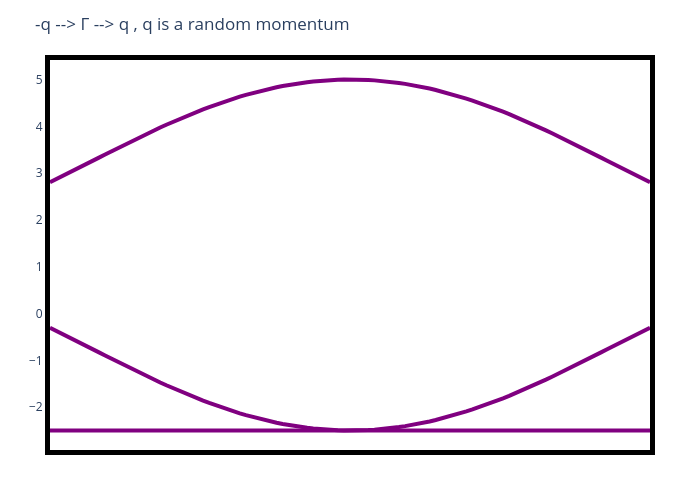

In [49]:
let nps::Int = 100, t1Δ = 1.0, t2Δ = 1.0, t3Δ = 1.0, t1∇ = 1.5, t2∇ = 1.5, t3∇ = 1.5
    p::Params = Params(t1Δ, t2Δ, t3Δ, t1∇, t2∇, t3∇)
    println("t1Δ = ", p.t1Δ)
    println("t2Δ = ", p.t2Δ)
    println("t3Δ = ", p.t3Δ)
    println("t1∇ = ", p.t1∇)
    println("t2∇ = ", p.t2∇)
    println("t3∇ = ", p.t3∇)

    kpoint = @SVector[3.02, 0.45]
    
    kpath_nodes::Vector{SVector{2, Float64}} = [-kpoint, 
                    high_symmetry_points["Γ"], 
                    kpoint];
    kpath_fbz::Vector{Vector{Float64}} = interpolate(kpath_nodes, nps);
    kpath_fbz = [SVector{2, Float64}(v) for v ∈ kpath_fbz]
    plot_simple_kagome_bands(;p = p, seedname = "-q --> Γ --> q , q is a random momentum", kpath = kpath_fbz, title = Nothing)
end


t1Δ = 1.0
t2Δ = 0.5
t3Δ = 2.0
t1∇ = -1.5
t2∇ = 0.7
t3∇ = -0.3


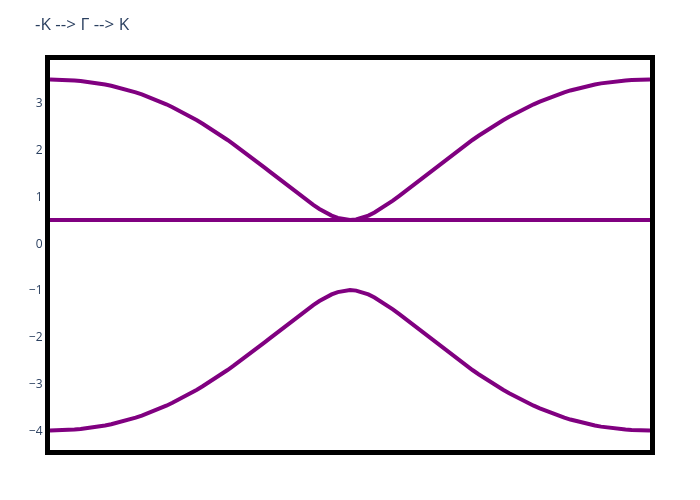

In [50]:
let nps::Int = 100, t1Δ = 1.0, t2Δ = 0.5, t3Δ = 2.0, t1∇ = -1.5, t2∇ = 0.7, t3∇ = -0.3
    p::Params = Params(t1Δ, t2Δ, t3Δ, t1∇, t2∇, t3∇)
    println("t1Δ = ", p.t1Δ)
    println("t2Δ = ", p.t2Δ)
    println("t3Δ = ", p.t3Δ)
    println("t1∇ = ", p.t1∇)
    println("t2∇ = ", p.t2∇)
    println("t3∇ = ", p.t3∇)
    
    kpath_nodes::Vector{SVector{2, Float64}} = [-high_symmetry_points["K"], 
                    high_symmetry_points["Γ"], 
                    high_symmetry_points["K"]];
    kpath_fbz::Vector{Vector{Float64}} = interpolate(kpath_nodes, nps);
    kpath_fbz = [SVector{2, Float64}(v) for v ∈ kpath_fbz]
    plot_simple_kagome_bands(;p = p, seedname = "-K --> Γ --> K", kpath = kpath_fbz, title = Nothing)
end


The band structure is still invariant under k --> -k. This arises from constraints from other symmetries. So, we need to take account of the full magnetic symmetry group to understand the model. One symmetry is obvious here, which is Time-Reversal symmetry. this forces the spectrum to be invariant as k --> -k 
Also, we note that in two-dimensions, there is no distinction between inversion and C2 (rotation by 180 degrees). We want to consider 1) proper rotations SO(2) and 2) Mirror (Reflections around certain lines), which have determinant -1 , so not topologically connected with elements in SO(2). 